In [ ]:
# package install
!pip install seaborn==0.11.2 scikit-learn==1.1.1 catboost==1.0.6

# Import Packages

In [11]:
import random as rnd
import warnings

import matplotlib.pyplot as plt
import numpy as np

# data analysis and wrangling
import pandas as pd

# visualization
import seaborn as sns

# load dataset
from catboost.datasets import titanic
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Model traning & selection
from sklearn.model_selection import (
    KFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)

# ML models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

warnings.filterwarnings("ignore")

# 1. EDA

We start by acquiring datasets using catboost library.  
We also combine these datasets into `dataset` to run certain operations on both datasets together.

In [12]:
train_df, test_df = titanic()
dataset = {
    "train": train_df,
    "test": test_df,
}
# We need `PassengerId` feature to make submit file.
passenger_id = test_df["PassengerId"]

## Describing data

### Types of Features
- **Categorical**: `Survived`, `Sex`, and `Embarked`.
- **Ordinal**: `Pclass`.
- **Continous**: `Age`, `Fare`.
- **Discrete**: `SibSp`, `Parch`.
- **Mixed data type**: `Ticket`, `Cabin`.

### Features contraining missing values
- Train set: `Cabin` > `Age` > `Embarked`
- Test set: `Cabin` > `Age` >> `Fare`

### Features to be dropped
- `Ticket` : It contains high ratio of duplicates.
- `Cabin` : It has many null values(77%, 38% for train and test set).
- `PassengerId` : It's not contribute to survival.
- `Name` : Title(like 'Mr' or 'Mrs' ...) may contribute to survival. 

In [3]:
print("Preview the data")
display(train_df.head())

print("\n" + "=" * 40)
print("Check blank, null or empty values\n")
print("\tTrain")
display(train_df.isnull().sum() / len(train_df))
print("_" * 40)
print("\tTest")
display(test_df.isnull().sum() / len(train_df))

print("\n" + "=" * 40)
print("Check the distribution of numerical features")
display(train_df.describe())

print("\n" + "=" * 40)
print("Check the distribution of categorical features")
display(train_df.describe(include=["O"]))

print("\n" + "=" * 40)
print("Check the duplication rate of `Ticket` feature")
train_df.Ticket.duplicated().sum() / len(train_df)

Preview the data


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Check blank, null or empty values

	Train


PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

________________________________________
	Test


PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.096521
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.001122
Cabin          0.367003
Embarked       0.000000
dtype: float64


Check the distribution of numerical features


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200



Check the distribution of categorical features


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644



Check the duplication rate of `Ticket` feature


0.2356902356902357

## Analyzing the features

### **Categorical**, **ordinal** or **discrete feature** and **target**
- **`Pclass`** : Passengers with `Pclass` 1 has a higher rate of surviving than other Pclasses.
- **`Sex`** : `Female` passengers are more likely to survive than male passengers
- **`SibSp` and `Parch`** : Survival rate differs depending on whether you are alone or when you have one other family member. 

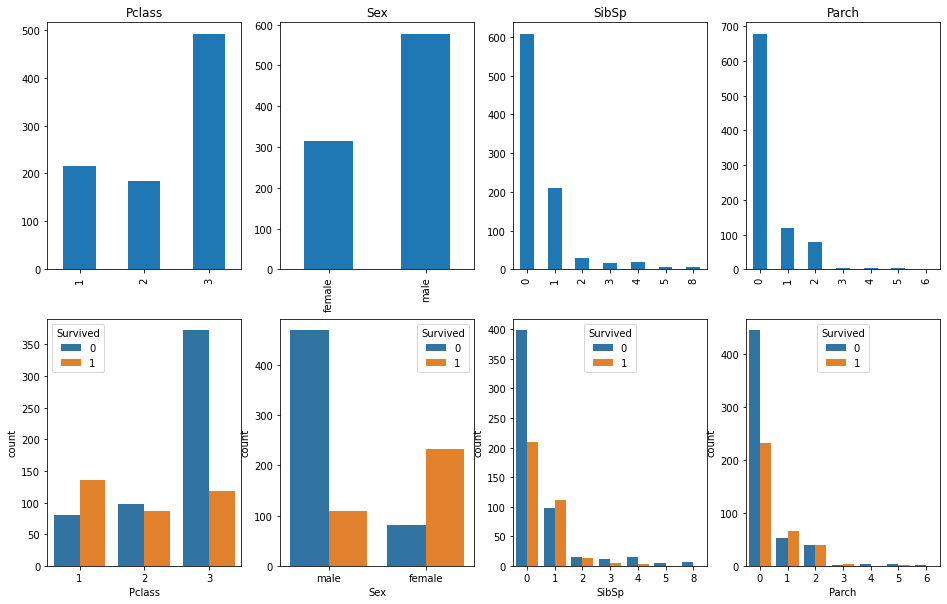

In [4]:
pivot_features = ["Pclass", "Sex", "SibSp", "Parch"]
f, ax = plt.subplots(2, 4, figsize=(16, 10))

for i, pivot_feature in enumerate(pivot_features):
    train_df[pivot_feature].value_counts().sort_index().plot.bar(x=pivot_feature, y="Survived", ax=ax[0, i])
    sns.countplot(pivot_feature, hue="Survived", data=train_df, ax=ax[1, i])
    ax[0, i].set_title(pivot_feature)
plt.show()

### Correlation between features

#### Fig 1 :  Histogram of `Age` by `Survived`
- Infants (Age <=4) had high survival rate.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.


#### Fig 2 : Distribution of `Age` by `Pclass` x `Survived`
- The number of children increases with `Pclass`
- The survival rate for passengers below `Age` 10 looks to be good irrespective of the `Pclass`.


#### Fig 3 : `Survived` rate by `Embarked` x `Pclass` x `Sex`
- The survival chances are almost 1 for `Pclass` 1 & 2 irrespecitive of the `Pclass`.
- Port S looks to be very unlucky for `Pclass` 3 Passenegers as the survival rate for both men and women is very low.
- Port Q looks to be unlukiest for Men, as almost all were from Pclass 3.


#### Fig 4 : `Fare` by `Embarked` x `Survived`
- The survival rate is high for passengers paying higher fare had better survival.
- Port of embarkation correlates with survival rates.

#### Decisions
- We should use `Age`, `Pclass`, `Embarked`, `Fare` feature to model training.
- Consider banding `Age`, `Fare` feature.
- Need to complete the `Age`, `Embarked`, `Fare` feature for missing values

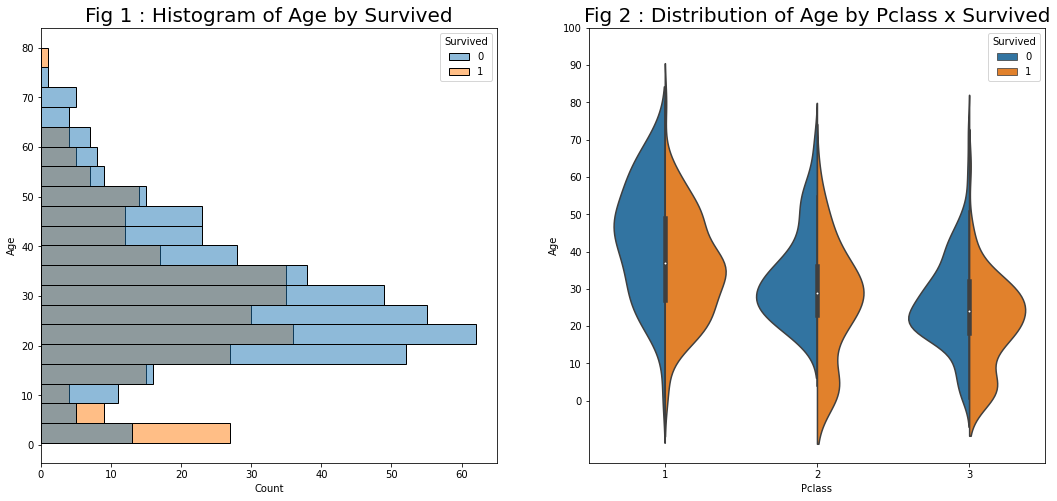

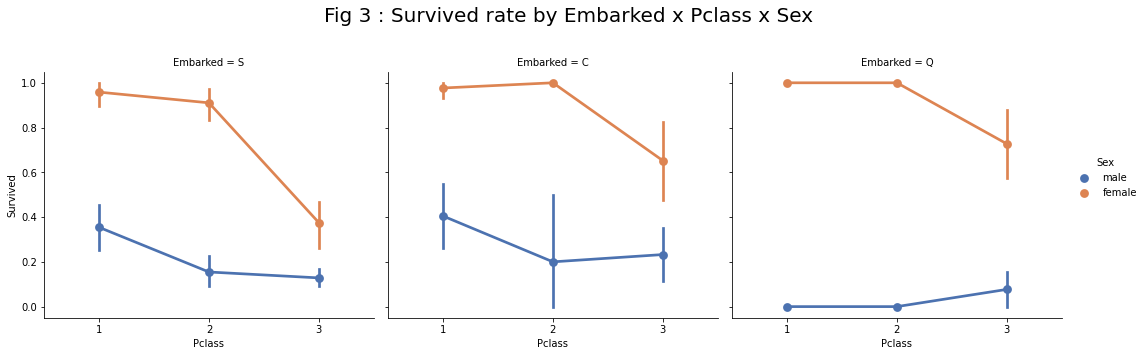

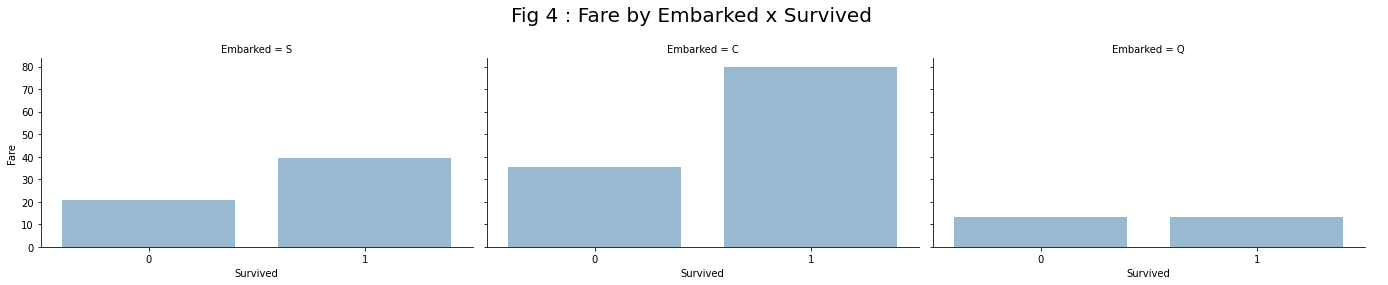

In [6]:
fig12, ax = plt.subplots(1, 2, figsize=(18, 8))
sns.histplot(data=train_df, y="Age", hue="Survived", ax=ax[0])
ax[0].set_title("Fig 1 : Histogram of Age by Survived", size=20)
sns.violinplot(data=train_df, x="Pclass", y="Age", hue="Survived", split=True, ax=ax[1])
ax[1].set_title("Fig 2 : Distribution of Age by Pclass x Survived", size=20)
ax[1].set_yticks(range(0, 110, 10))
plt.show()

fig3 = sns.factorplot("Pclass", "Survived", data=train_df, hue="Sex", col="Embarked", palette="deep")
fig3.fig.subplots_adjust(top=0.8)
fig3.fig.suptitle("Fig 3 : Survived rate by Embarked x Pclass x Sex", size=20)
plt.show()

fig4 = sns.FacetGrid(train_df, col="Embarked", size=4, aspect=1.6)
fig4.map(sns.barplot, "Survived", "Fare", alpha=0.5, ci=None)
fig4.add_legend()
fig4.fig.subplots_adjust(top=0.8)
fig4.fig.suptitle("Fig 4 : Fare by Embarked x Survived", size=20)

plt.show()

---

# 2. Wrangling data

## Dropping features
- `Ticket`, `Cabin`, `PassengerId`

In [1]:
for ds_name, ds in dataset.items():
    ds.drop(["Ticket", "Cabin", "PassengerId"], axis=1, inplace=True)
    dataset[ds_name] = ds

## Creating feature : `Title`

- Extract `Title` and test correlation between `Title` and `Survived`.
- By RegEx pattern, we can find the first word which ends with a dot(`.`) within `Name` feature.

### the number of samples by Title x Sex
- Most titles are gender-specific. For example: None of the samples with `Master` or `Mr` titles were `female`.

### the survival rate by Title
- Certain titles mostly survived (`Miss`, `Mrs`) or did

### the mean value of Age by Title
- Most titles band Age groups accurately. For example: Master title has Age mean of 5 years.

### Decision
- We decide to retain the new `Title` feature for model training.

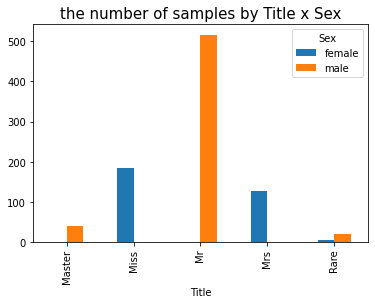

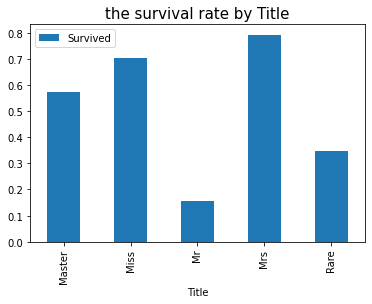

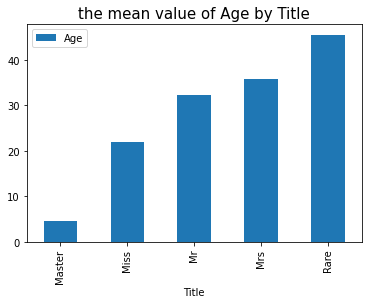

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [3]:
for ds_name, ds in dataset.items():
    ds["Title"] = ds.Name.str.extract(
        " ([A-Za-z]+)\.",
        expand=False,
    )
    ds["Title"] = ds["Title"].replace(
        ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"],
        "Rare",
    )
    ds["Title"] = ds["Title"].replace("Mlle", "Miss")
    ds["Title"] = ds["Title"].replace("Ms", "Miss")
    ds["Title"] = ds["Title"].replace("Mme", "Mrs")
    ds["Title"] = ds["Title"].fillna(0)
    ds = ds.drop(["Name"], axis=1)
    dataset[ds_name] = ds

pd.crosstab(dataset["train"]["Title"], dataset["train"]["Sex"]).plot.bar()
plt.title("the number of samples by Title x Sex", size=15)
plt.show()
dataset["train"][["Title", "Survived"]].groupby(["Title"], as_index=False).mean().plot.bar(x="Title")
plt.title("the survival rate by Title", size=15)
plt.show()
dataset["train"][["Title", "Age"]].groupby(["Title"], as_index=False).mean().plot.bar(x="Title")
plt.title("the mean value of Age by Title", size=15)
plt.show()
display(dataset["train"].head())

## Completing features
- `Age`, `Embarked`, `Fare`

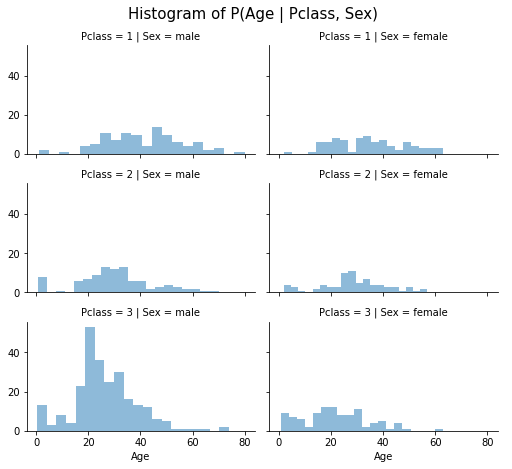

In [ ]:
# Cross tab Pclass x Sex(X ~ P(Age | Sex, Pclass))
grid = sns.FacetGrid(dataset["train"], row="Pclass", col="Sex", size=2.2, aspect=1.6)
grid.map(plt.hist, "Age", alpha=0.5, bins=20)
grid.add_legend()
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle("Histogram of P(Age | Pclass, Sex)", size=15)
plt.show()

freq_port = dataset["train"].Embarked.dropna().mode()[0]
categ_sex = dataset["train"].Sex.unique()

for ds_name, ds in dataset.items():
    # Complete Age feature with the median of X ~ P(Age | Sex, Pclass)
    for i in range(2):
        for j in range(3):
            guess_df = ds[(ds["Sex"] == categ_sex[i]) & (ds["Pclass"] == j + 1)]["Age"].dropna()

            ds.loc[(ds.Age.isnull()) & (ds.Sex == categ_sex[i]) & (ds.Pclass == j + 1), "Age"] = guess_df.median()

    ds["Embarked"].fillna(freq_port, inplace=True)
    ds["Fare"].fillna(ds["Fare"].dropna().median(), inplace=True)
    dataset[ds_name] = ds

## Converting features
- `Age`, `Fare`
- Convert Numeric feature to Ordinal.

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,"Braund, Mr. Owen Harris",0,1,1,0,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,3,1,3
2,1,3,"Heikkinen, Miss. Laina",1,1,0,0,1,0,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,3,0,3
4,0,3,"Allen, Mr. William Henry",0,2,0,0,1,0,1


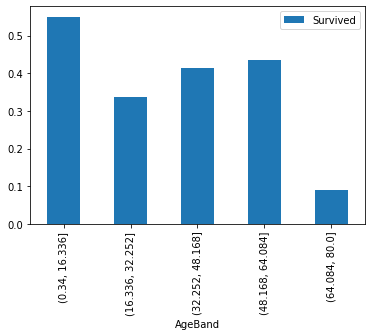

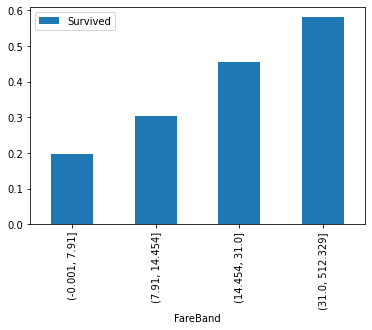

In [9]:
# Banding `Age`, `Fare` feature
dataset["train"]["AgeBand"] = pd.cut(dataset["train"]["Age"], 5)
dataset["train"][["AgeBand", "Survived"]].groupby(["AgeBand"], as_index=False,).mean().sort_values(
    by="AgeBand",
    ascending=True,
).plot.bar(x="AgeBand")
dataset["train"] = dataset["train"].drop(["AgeBand"], axis=1)

dataset["train"]["FareBand"] = pd.qcut(dataset["train"]["Fare"], 4)
dataset["train"][["FareBand", "Survived"]].groupby(["FareBand"], as_index=False,).mean().sort_values(
    by="FareBand",
    ascending=True,
).plot.bar(x="FareBand")
dataset["train"] = dataset["train"].drop(["FareBand"], axis=1)

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
sex_mapping = {"female": 1, "male": 0}
embarked_mapping = {"S": 0, "C": 1, "Q": 2}

for ds_name, ds in dataset.items():
    # Convert Numeric feature to Ordinal : `Age`, `Fare`
    ds.loc[ds["Age"] <= 16, "Age"] = 0
    ds.loc[(ds["Age"] > 16) & (ds["Age"] <= 32), "Age"] = 1
    ds.loc[(ds["Age"] > 32) & (ds["Age"] <= 48), "Age"] = 2
    ds.loc[(ds["Age"] > 48) & (ds["Age"] <= 64), "Age"] = 3
    ds.loc[ds["Age"] > 64, "Age"]
    ds["Age"] = ds["Age"].astype(int)

    ds.loc[ds["Fare"] <= 7.91, "Fare"] = 0
    ds.loc[(ds["Fare"] > 7.91) & (ds["Fare"] <= 14.454), "Fare"] = 1
    ds.loc[(ds["Fare"] > 14.454) & (ds["Fare"] <= 31), "Fare"] = 2
    ds.loc[ds["Fare"] > 31, "Fare"] = 3
    ds["Fare"] = ds["Fare"].astype(int)

    # Convert Categorical feature to numeric : `Title`, `Sex`
    ds["Title"] = ds["Title"].map(title_mapping)
    ds["Title"] = ds["Title"].fillna(0)
    ds["Sex"] = ds["Sex"].map(sex_mapping).astype(int)
    ds["Embarked"] = ds["Embarked"].map(embarked_mapping).astype(int)

    dataset[ds_name] = ds

display(dataset["train"].head())

## Creating features : `IsAlone`, `Age*Class`

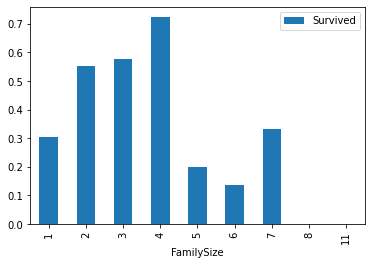

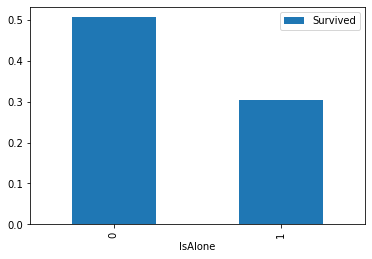

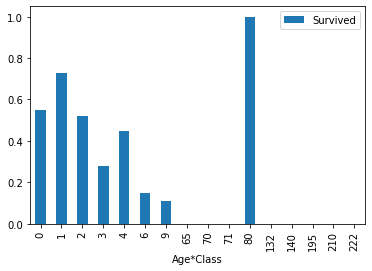

In [10]:
for ds_name, ds in dataset.items():
    # We can create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.
    ds["FamilySize"] = ds["SibSp"] + ds["Parch"] + 1

    # We can create another feature called IsAlone.
    ds["IsAlone"] = 0
    ds.loc[ds["FamilySize"] == 1, "IsAlone"] = 1

    # Let us drop Parch, SibSp, and FamilySize features in favor of IsAlone.
    ds = ds.drop(["Parch", "SibSp"], axis=1)

    # We can also create an artificial feature combining Age and Pclass.
    ds["Age*Class"] = ds.Age * ds.Pclass
    dataset[ds_name] = ds

dataset["train"][["FamilySize", "Survived"]].groupby(
    ["FamilySize"],
    as_index=False,
).mean().plot.bar(x="FamilySize")
dataset["train"][["IsAlone", "Survived"]].groupby(
    ["IsAlone"],
    as_index=False,
).mean().plot.bar(x="IsAlone")
dataset["train"][["Age*Class", "Survived"]].groupby(
    ["Age*Class"],
    as_index=False,
).mean().plot.bar(x="Age*Class")

for ds_name, ds in dataset.items():
    ds = ds.drop(["FamilySize"], axis=1)
    dataset[ds_name] = ds

---

# 3. Model, predict and solve
1. Gaussian Naive Bayes
2. KNN or k-Nearest Neighbors
3. Logistic Regression
4. Random Forrest

## Prepare Train & Val set

In [6]:
train, val = train_test_split(dataset["train"], test_size=0.3, random_state=0, stratify=dataset["train"]["Survived"])

X_train = train.iloc[:, 1:]
Y_train = train.iloc[:, :1]
X_val = val.iloc[:, 1:]
Y_val = val.iloc[:, :1]

X = dataset["train"][dataset["train"].columns[1:]]
Y = dataset["train"]["Survived"]

## Gaussian Naive Bayes

In [ ]:
clf_gsnb = GaussianNB()
clf_gsnb.fit(X_train, Y_train)
pred_gsnb = clf_gsnb.predict(X_val)
acc_gsnb = metrics.accuracy_score(pred_gsnb, Y_val)
print(f"The accuracy of the Gaussian NB is {acc_gsnb}")

The accuracy of the Gaussian NB is 0.7574626865671642


## K-Nearest Neighbours(KNN)

The accuracy of the KNN is 0.7985074626865671


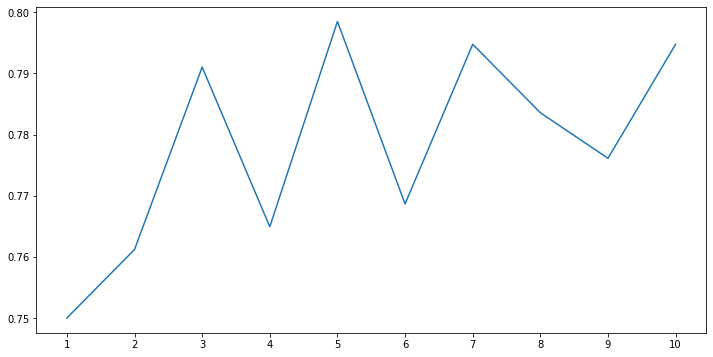

Accuracies for different values of n are: [0.75       0.76119403 0.79104478 0.76492537 0.79850746 0.76865672
 0.79477612 0.78358209 0.7761194  0.79477612] with the max value as  0.7985074626865671


In [6]:
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(X_train, Y_train)
pred_knn = clf_knn.predict(X_val)
acc_knn = metrics.accuracy_score(pred_knn, Y_val)
print(f"The accuracy of the KNN is {acc_knn}")

search_range = list(range(1, 11))
a = pd.Series()
for i in search_range:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train, Y_train)
    prediction = model.predict(X_val)
    a = a.append(pd.Series(metrics.accuracy_score(prediction, Y_val)))

plt.plot(search_range, a)
plt.xticks(search_range)
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()
print("Accuracies for different values of n are:", a.values, "with the max value as ", a.values.max())
del a, i, search_range, model, prediction, fig

## Logistic Regression

In [8]:
# Logistic Regression
clf_lg = LogisticRegression()
clf_lg.fit(X_train, Y_train)
pred_lg = clf_lg.predict(X_val)
acc_lg = metrics.accuracy_score(pred_lg, Y_val)
print(f"The accuracy of the Logistic Regression is {acc_lg}")

# Check Coefficients of the features
coeff_df = pd.DataFrame(dataset["train"].columns.delete(0))
coeff_df.columns = ["Feature"]
coeff_df["Correlation"] = pd.Series(clf_lg.coef_[0])
display(coeff_df.sort_values(by="Correlation", ascending=False))

The accuracy of the Logistic Regression is 0.8246268656716418


,Feature,Correlation
1,Sex,2.173073
5,Title,0.373390
6,IsAlone,0.255659
2,Age,0.231659
4,Embarked,0.157717
3,Fare,0.093260
7,Age*Class,-0.249048
0,Pclass,-0.676265


## Random Forest

The accuracy of the Random Forest is 0.8134328358208955


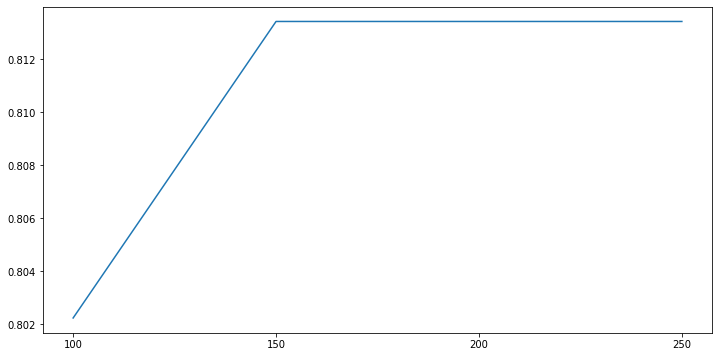

Accuracies for different values of n are: [0.80223881 0.81343284 0.81343284 0.81343284] with the max value as  0.8134328358208955


In [4]:
clf_rf = RandomForestClassifier(n_estimators=150, random_state=42)
clf_rf.fit(X_train, Y_train)
pred_rf = clf_rf.predict(X_val)
acc_rf = metrics.accuracy_score(pred_rf, Y_val)
print(f"The accuracy of the Random Forest is {acc_rf}")

search_range = list(range(100, 300, 50))
a = pd.Series()
for i in search_range:
    model = RandomForestClassifier(n_estimators=i, random_state=42)
    model.fit(X_train, Y_train)
    prediction = model.predict(X_val)
    a = a.append(pd.Series(metrics.accuracy_score(prediction, Y_val)))
plt.plot(search_range, a)
plt.xticks(search_range)
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()
print("Accuracies for different values of n are:", a.values, "with the max value as ", a.values.max())
del a, i, search_range, model, prediction, fig

---

# 4. Model evaluation

## K-Fold Cross Validation

,CV Mean,Std
Gaussian Naive Bayes,0.711573,0.071717
KNN,0.801411,0.039478
Logistic Regression,0.804707,0.038364
Random Forest,0.800287,0.038103


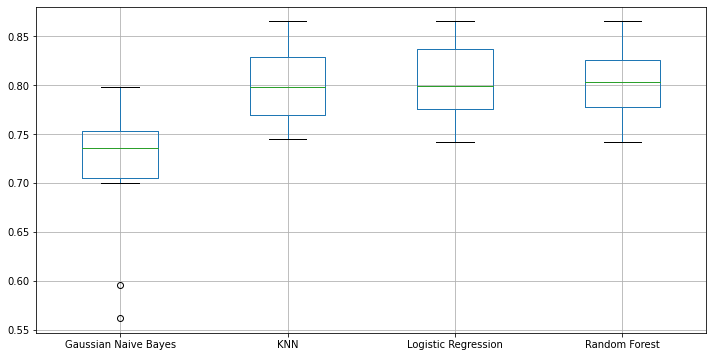

In [24]:
kfold = KFold(n_splits=10)  # k=10, split the data into 10 equal parts
cv_mean = []
accuracy = []
std = []
classifiers = ["Gaussian Naive Bayes", "KNN", "Logistic Regression", "Random Forest"]
model_list = [
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=5),
    LogisticRegression(),
    RandomForestClassifier(n_estimators=150, random_state=42),
]
for model in model_list:
    cv_result = cross_val_score(model, X, Y, cv=kfold, scoring="accuracy")
    cv_mean.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)

df_kfold_result = pd.DataFrame(
    {"CV Mean": cv_mean, "Std": std},
    index=classifiers,
)
display(df_kfold_result)

plt.subplots(figsize=(12, 6))
box = pd.DataFrame(accuracy, index=classifiers)
box.T.boxplot()
plt.show()

## Confusion Matrix

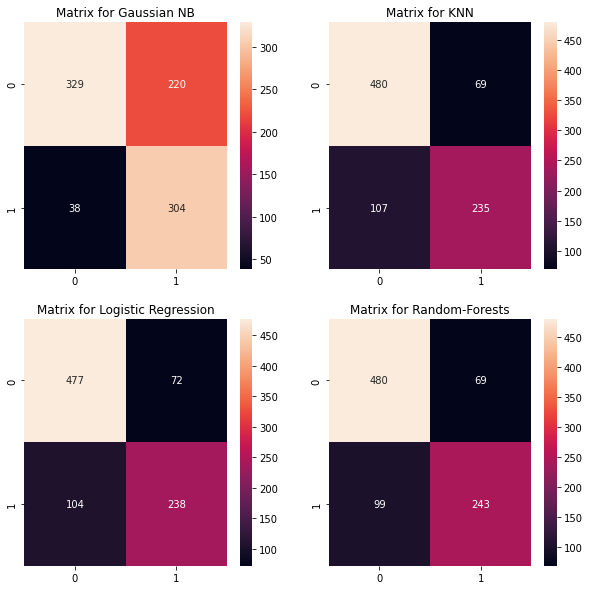

In [23]:
f, ax = plt.subplots(2, 2, figsize=(10, 10))
y_pred = cross_val_predict(GaussianNB(), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[0, 0], annot=True, fmt="2.0f")
ax[0, 0].set_title("Matrix for Gaussian NB")

y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[0, 1], annot=True, fmt="2.0f")
ax[0, 1].set_title("Matrix for KNN")

y_pred = cross_val_predict(LogisticRegression(), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[1, 0], annot=True, fmt="2.0f")
ax[1, 0].set_title("Matrix for Logistic Regression")

y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[1, 1], annot=True, fmt="2.0f")
ax[1, 1].set_title("Matrix for Random-Forests")

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

# 5. Ensemble & Submission

In [27]:
ensemble_clf = VotingClassifier(
    estimators=list(zip(classifiers, model_list)),
    voting="hard",
).fit(X_train, Y_train)
print("The accuracy for ensembled model is:", ensemble_clf.score(X_val, Y_val))
cross = cross_val_score(ensemble_clf, X, Y, cv=10, scoring="accuracy")
print("The cross validated score is", cross.mean())

The accuracy for ensembled model is: 0.8283582089552238
The cross validated score is 0.8092759051186018


In [13]:
Y_pred = ensemble_clf.predict(dataset["test"])
Y_pred
df_submission = pd.DataFrame({"PassengerId": passenger_id, "Survived": Y_pred})
display(df_submission.head())
df_submission.to_csv("submission.csv", index=False)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


Our submission to the competition site Kaggle results in scoring 3,199 of 13,802 competition entries.

## References
- [A journey through Titanic](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic)
- [Getting Started with Pandas: Kaggle's Titanic Competition](https://www.kaggle.com/c/titanic/details/getting-started-with-random-forests)
- [Titanic Best Working Classifier](https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier)
- [Titanic Data Science Solutions](https://www.kaggle.com/code/startupsci/titanic-data-science-solutions/notebook)
- [EDA To Prediction(DieTanic)](https://www.kaggle.com/code/ash316/eda-to-prediction-dietanic)